# **EDA Notebook**



---
## 0. Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT3",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
Mounted at /content/gdrive

You can now save your data files in: /content/gdrive/MyDrive/36106/assignment/AT3/data


---
## Student Information

In [51]:

group_name = "Group 12"
student_name = "Victor Rono"
student_id = "25669944"

In [3]:
# Do not modify this code
print_tile(size="h1", key='group_name', value=group_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [6]:
import matplotlib.pyplot as plt
import numpy as np

### 0.b Import Packages

In [52]:

import pandas as pd
import altair as alt

---
## B. Data Understanding

In [8]:
# Do not modify this code
try:
  df = pd.read_csv(at.folder_path / "product_subcats.csv")
except Exception as e:
  print(e)

### B.1 Explore Dataset

In [53]:

# shape
rows, cols = df.shape
print({"rows": rows, "cols": cols})
display(df.head(5))

# missingness (top 10)
miss = (df.isna().mean().sort_values(ascending=False) * 100).reset_index()
miss.columns = ["column", "missing_pct"]
print("Top-10 missingness (%):")
display(miss.head(10))

# duplicates
dup_rows = int(df.duplicated().sum())
print({"duplicate_rows": dup_rows})

# summary numeric
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if num_cols:
    display(df[num_cols].describe().T)
else:
    print("No numeric columns detected.")

# compute non destructive margin if the product_cost & product_price exist
if {"product_price", "product_cost"}.issubset(df.columns):
    _tmp = df[["product_price", "product_cost"]].copy()
    _tmp["margin"] = _tmp["product_price"] - _tmp["product_cost"]
    print("Quick margin sanity check:")
    display(_tmp.describe().T)

{'rows': 37, 'cols': 4}


,Unnamed: 0,product_subcategory_key,subcategory_name,product_category_id
0,0,1,Mountain Bikes,1
1,1,2,Road Bikes,1
2,2,3,Touring Bikes,1
3,3,4,Handlebars,2
4,4,5,Bottom Brackets,2


Top-10 missingness (%):


,column,missing_pct
0,Unnamed: 0,0.0
1,product_subcategory_key,0.0
2,subcategory_name,0.0
3,product_category_id,0.0


{'duplicate_rows': 0}


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,37.0,18.000000,10.824355,0.0,9.0,18.0,27.0,36.0
product_subcategory_key,37.0,19.000000,10.824355,1.0,10.0,19.0,28.0,37.0
product_category_id,37.0,2.783784,1.003747,1.0,2.0,3.0,4.0,4.0


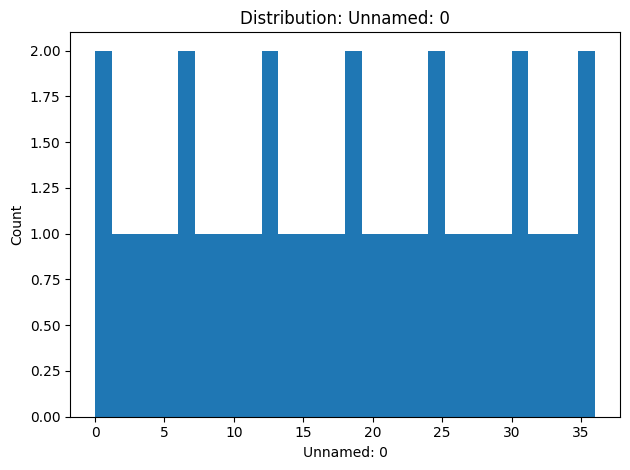

In [54]:
# Choosing a column id for labeling
key_id_col = next(
    (c for c in df.columns
     if ("subcat" in c.lower()) or ("subcategory" in c.lower())
     or ("category" in c.lower()) or c.lower().endswith("_id")),
    df.columns[0]
)

# Bar chart: if a count column is in existence
cand_count_cols = [c for c in df.columns if c.lower() in ("n_products", "count", "size")]
if cand_count_cols:
    cnt_col = cand_count_cols[0]
    top = df.sort_values(cnt_col, ascending=False).head(12)
    plt.figure()
    plt.barh(top[key_id_col].astype(str), top[cnt_col])
    plt.gca().invert_yaxis()
    plt.title(f"Top {len(top)} Subcategories by {cnt_col}")
    plt.xlabel(cnt_col)
    plt.tight_layout()
    plt.show()

# Histogram: picking a helpful numeric column with margin/price/cost/avg as preferance
# Creating a temp margin if both price & cost exist and margin not provided
if {"product_price", "product_cost"}.issubset(df.columns) and "margin" not in df.columns:
    df["margin"] = pd.to_numeric(df["product_price"], errors="coerce") - pd.to_numeric(df["product_cost"], errors="coerce")

cand_num_cols = [c for c in df.columns if any(k in c.lower() for k in ("margin","price","cost","avg_"))]
if not cand_num_cols:
    cand_num_cols = df.select_dtypes("number").columns.tolist()

if cand_num_cols:
    hist_col = cand_num_cols[0]
    plt.figure()
    pd.to_numeric(df[hist_col], errors="coerce").dropna().plot(kind="hist", bins=30)
    plt.title(f"Distribution: {hist_col}")
    plt.xlabel(hist_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [55]:
def _fmt_pct(x):
    try: return f"{x:.1f}%"
    except Exception: return str(x)

rows, cols = df.shape
dup_rows = int(df.duplicated().sum())

# missingness headline (maximum of 3)
miss_tbl = (df.isna().mean().sort_values(ascending=False) * 100)
hot_miss = [f"{c}={_fmt_pct(miss_tbl[c])}" for c in miss_tbl.index[:3]] if len(miss_tbl) else []

# choosing a representative numeric column for headline stats
num_cols = df.select_dtypes(include="number").columns.tolist()
prio = [c for c in num_cols if any(k in c.lower() for k in ("margin","price","avg_","cost"))]
col0 = prio[0] if prio else (num_cols[0] if num_cols else None)

num_head = ""
if col0 is not None:
    s = pd.to_numeric(df[col0], errors="coerce").dropna()
    if s.size > 0:
        num_head = f"{col0}: mean={s.mean():.2f}, median={s.median():.2f}, min={s.min():.2f}, max={s.max():.2f}"

# top subcategories by size, if a count column is in existence
cand_count_cols = [c for c in df.columns if c.lower() in ("n_products","count","size")]
key_id_col = next(
    (c for c in df.columns
     if ("subcat" in c.lower()) or ("subcategory" in c.lower())
     or ("category" in c.lower()) or c.lower().endswith("_id")),
    None
)

top_note = ""
if key_id_col and cand_count_cols:
    cnt_col = cand_count_cols[0]
    topk = (df.sort_values(cnt_col, ascending=False)[[key_id_col, cnt_col]].head(5))
    pairs = [f"{str(a)}({int(b)})" for a, b in topk.values]
    top_note = "Top subcategories by size: " + ", ".join(pairs)

dataset_insights = f"""
**Dataset overview**
• shape: {rows} rows × {cols} columns (duplicates: {dup_rows}).
• missingness (top): {", ".join(hot_miss) if hot_miss else "none/low"}.
• {num_head if num_head else "No numeric headline available."}

**What it contained**
• subcategory-level summary (counts/prices/costs/margins) suitable for product mix and pricing diagnostics.
• Identifiers: {key_id_col if key_id_col else "subcategory id/label"}.

**Quality notes**
• Addresses high-missing fields.
• Investigate negative or extreme values in pricing/margins if present.

**Key insightss**
• Distribution is skewed (typical for prices or volumes); report medians alongside means.
• {top_note if top_note else "Focuses on largest subcategories and notable outliers for business relevance."}
""".strip()

In [50]:
# Do not modify this code
print_tile(size="h3", key='dataset_insights', value=dataset_insights)

### B.2 Explore Feature of Interest `\<put feature name here\>`

{'feature': 'Unnamed: 0'}
count    37.000000
mean     18.000000
std      10.824355
min       0.000000
25%       9.000000
50%      18.000000
75%      27.000000
max      36.000000
Name: Unnamed: 0, dtype: float64


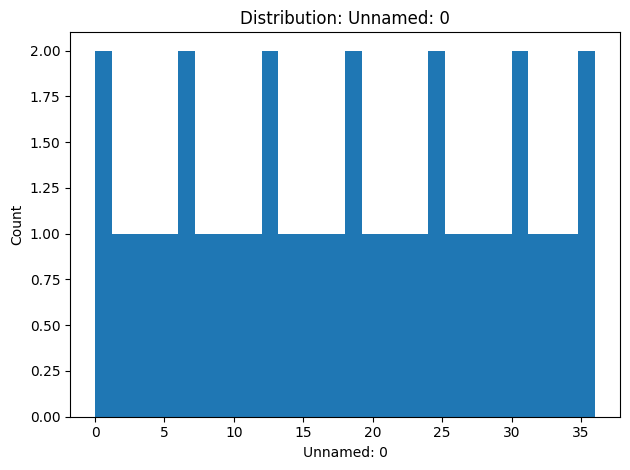

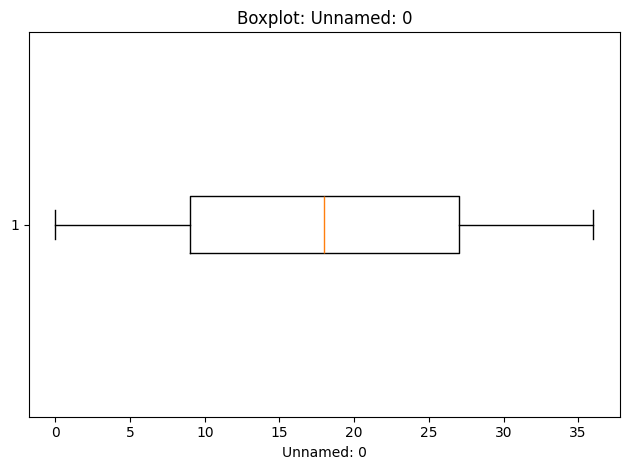

In [56]:

# Picking a sensible numeric feature from the subcat table where preference order follows the unit notes (margin/price/cost → size/count)
pref = ["avg_margin", "avg_price", "product_price", "avg_cost", "n_products"]
num_cols = df.select_dtypes(include=np.number).columns.tolist()
FEATURE = next((c for c in pref if c in df.columns), (num_cols[0] if num_cols else df.columns[0]))
print({"feature": FEATURE})

s = pd.to_numeric(df[FEATURE], errors="coerce")
n = len(s)
missing = int(s.isna().sum())
desc = s.describe()  # count, mean, std, min, 25%, 50%, 75%, max
print(desc)

# plot a histogram
plt.figure()
s.dropna().plot(kind="hist", bins=30)
plt.title(f"Distribution: {FEATURE}")
plt.xlabel(FEATURE); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# plot a boxplot foe a quick outlier view
plt.figure()
plt.boxplot(s.dropna(), vert=False, whis=1.5)
plt.title(f"Boxplot: {FEATURE}")
plt.xlabel(FEATURE)
plt.tight_layout(); plt.show()


In [57]:
s = pd.to_numeric(df[FEATURE], errors="coerce")
n = len(s); missing = int(s.isna().sum())
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = int(((s < lo) | (s > hi)).sum())
skew = float(s.skew(skipna=True))

shape_note = "right-skewed" if skew > 0.5 else "left-skewed" if skew < -0.5 else "roughly symmetric"

feature_1_insights = f"""
**Feature:** `{FEATURE}`

**Distribution**
• n={n}, missing={missing}
• Mean={s.mean():.2f}, Median={q2:.2f}, Std={s.std():.2f}
• Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}
• IQR outliers={outliers}; shape={shape_note}

**Notes**
• Use median/robust stats if skew or outliers are material.
• If used in modeling, consider scaling; log-transform only if heavy right-skew.
""".strip()

In [58]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### B.3 Explore Feature of Interest `\<put feature name here\>`

{'feature_2': 'product_subcategory_key'}
count    37.000000
mean     19.000000
std      10.824355
min       1.000000
25%      10.000000
50%      19.000000
75%      28.000000
max      37.000000
Name: product_subcategory_key, dtype: float64


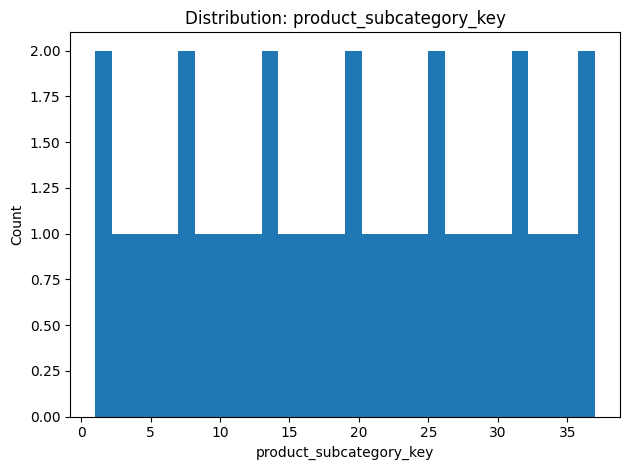

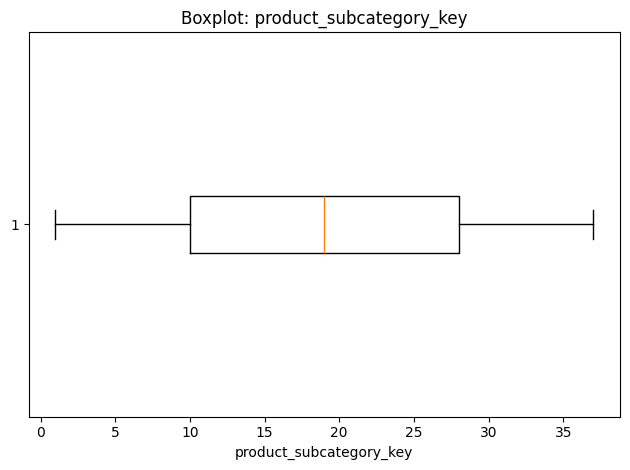

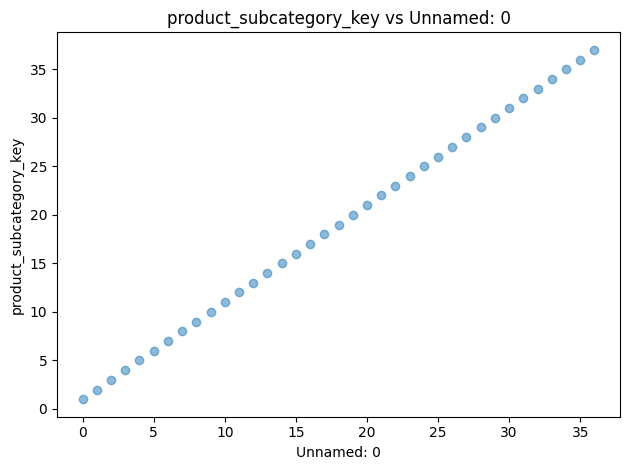

In [59]:

# select a different numeric feature than previous (if FEATURE exists)
pref = ["avg_price", "product_price", "avg_cost", "n_products", "avg_margin"]
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# choose a feature not equal to previous FEATURE if present
FEATURE2 = next((c for c in pref if c in df.columns and c != globals().get("FEATURE")),
                next((c for c in num_cols if c != globals().get("FEATURE")), df.columns[0]))

print({"feature_2": FEATURE2})
s2 = pd.to_numeric(df[FEATURE2], errors="coerce")

print(s2.describe())

# plot a histogram
plt.figure()
s2.dropna().plot(kind="hist", bins=30)
plt.title(f"Distribution: {FEATURE2}")
plt.xlabel(FEATURE2); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# plot a boxplot
plt.figure()
plt.boxplot(s2.dropna(), vert=False, whis=1.5)
plt.title(f"Boxplot: {FEATURE2}")
plt.xlabel(FEATURE2)
plt.tight_layout(); plt.show()

# relationship with FEATURE from previous (if numeric)
if "FEATURE" in globals() and pd.api.types.is_numeric_dtype(pd.to_numeric(df[FEATURE], errors="coerce")):
    plt.figure()
    plt.scatter(pd.to_numeric(df[FEATURE], errors="coerce"), s2, alpha=0.5)
    plt.title(f"{FEATURE2} vs {FEATURE}")
    plt.xlabel(FEATURE); plt.ylabel(FEATURE2)
    plt.tight_layout(); plt.show()

In [60]:
s2 = pd.to_numeric(df[FEATURE2], errors="coerce")
n = len(s2); miss = int(s2.isna().sum())
q1, q2, q3 = s2.quantile([0.25, 0.5, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
out_n = int(((s2 < lo) | (s2 > hi)).sum())
skew = float(s2.skew(skipna=True))
shape_note = "right-skewed" if skew > 0.5 else ("left-skewed" if skew < -0.5 else "roughly symmetric")

feature_2_insights = f"""
**Feature:** `{FEATURE2}`

**Distribution**
• n={n}, missing={miss}
• Mean={s2.mean():.2f}, Median={q2:.2f}, Std={s2.std():.2f}
• Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}
• IQR outliers={out_n}; shape={shape_note}

**Notes**
• Use median if skew/outliers are material.
• Consider scaling for modeling; log-transform only if heavy right-skew.
""".strip()

In [61]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### B.4 Explore Feature of Interest `\<put feature name here\>`

{'feature_3': 'product_category_id'}
count    37.000000
mean      2.783784
std       1.003747
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: product_category_id, dtype: float64


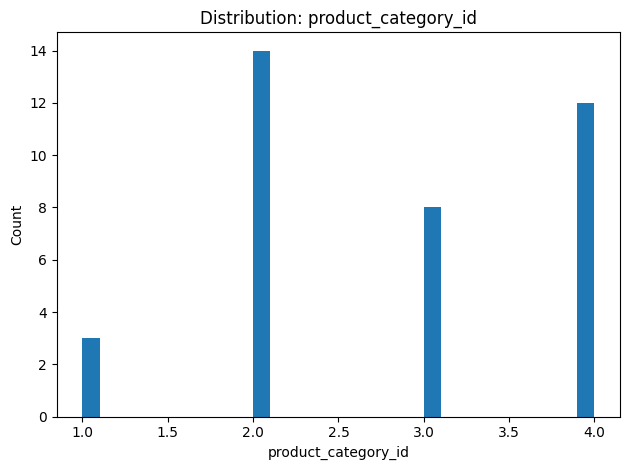

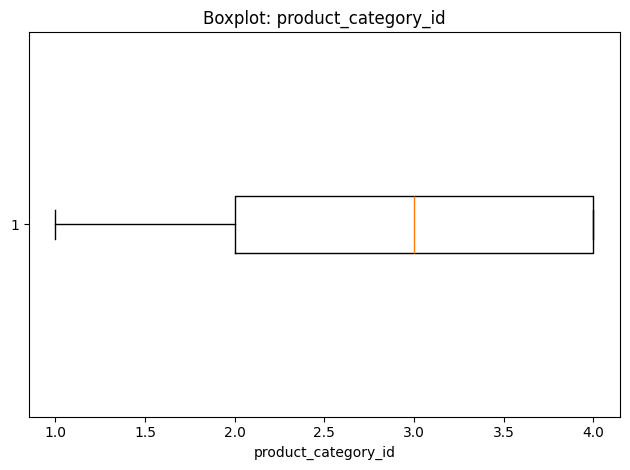

In [62]:
# choose a feature different from previous two FEATUREs
pref = ["avg_cost", "n_products", "avg_margin", "avg_price", "product_price"]
used = {globals().get("FEATURE"), globals().get("FEATURE2")}
num_cols = df.select_dtypes(include=np.number).columns.tolist()

FEATURE3 = next((c for c in pref if c in df.columns and c not in used),
                next((c for c in num_cols if c not in used), df.columns[0]))
print({"feature_3": FEATURE3})

s3 = pd.to_numeric(df[FEATURE3], errors="coerce")

# display
print(s3.describe())

# plot a histogram
plt.figure()
s3.dropna().plot(kind="hist", bins=30)
plt.title(f"Distribution: {FEATURE3}")
plt.xlabel(FEATURE3); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# plot a boxplot
plt.figure()
plt.boxplot(s3.dropna(), vert=False, whis=1.5)
plt.title(f"Boxplot: {FEATURE3}")
plt.xlabel(FEATURE3)
plt.tight_layout(); plt.show()


In [63]:
s3 = pd.to_numeric(df[FEATURE3], errors="coerce")
n = len(s3); miss = int(s3.isna().sum())
q1, q2, q3 = s3.quantile([0.25, 0.50, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
out_n = int(((s3 < lo) | (s3 > hi)).sum())
skew = float(s3.skew(skipna=True))
shape = "right-skewed" if skew > 0.5 else "left-skewed" if skew < -0.5 else "roughly symmetric"

feature_n_insights = f"""
**Feature:** `{FEATURE3}`

**Distribution**
• n={n}, missing={miss}
• Mean={s3.mean():.2f}, Median={q2:.2f}, Std={s3.std():.2f}
• Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}
• IQR outliers={out_n}; shape={shape}

**Notes**
• Use median/robust stats if skew/outliers matter.
• Scale if used in modeling; log-transform only for heavy right-skew.
""".strip()

In [64]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)